# Classification of Headlines for Irish News Dataset 

This dataset obtained from kaggle(https://www.kaggle.com/therohk/ireland-historical-news)has 1.42 million news headlines published by The Irish Times based in Ireland. Daily headlines of the newspaper starting from 1996-01-01 to 2018-12-31 gives a long term birds eye view of the happenings within Europe. This kaggle news dataset has it’s news headlines divided into 156 categories. As we can see below for each headline, publish date and the category it belongs to is provided.

In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re, string
import sys
import time
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(0)
nltk.download('wordnet')
df = pd.read_csv('irishtimes-date-text.csv')
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pguttula/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,publish_date,headline_category,headline_text
0,19960102,news,UUP sees possibility of voting Major out
1,19960102,news,Pubs targeted as curbs on smoking are extended
2,19960102,news,Papers reveal secret links with O'Neill cabinet
3,19960102,news,Domestic chaos as Italy takes EU presidency
4,19960102,news,Learning about the star to which we owe life


# DATA VISUALIZATION

Let us do some data visualization to understand our dataset better.

Total number of labels in the dataset: 156


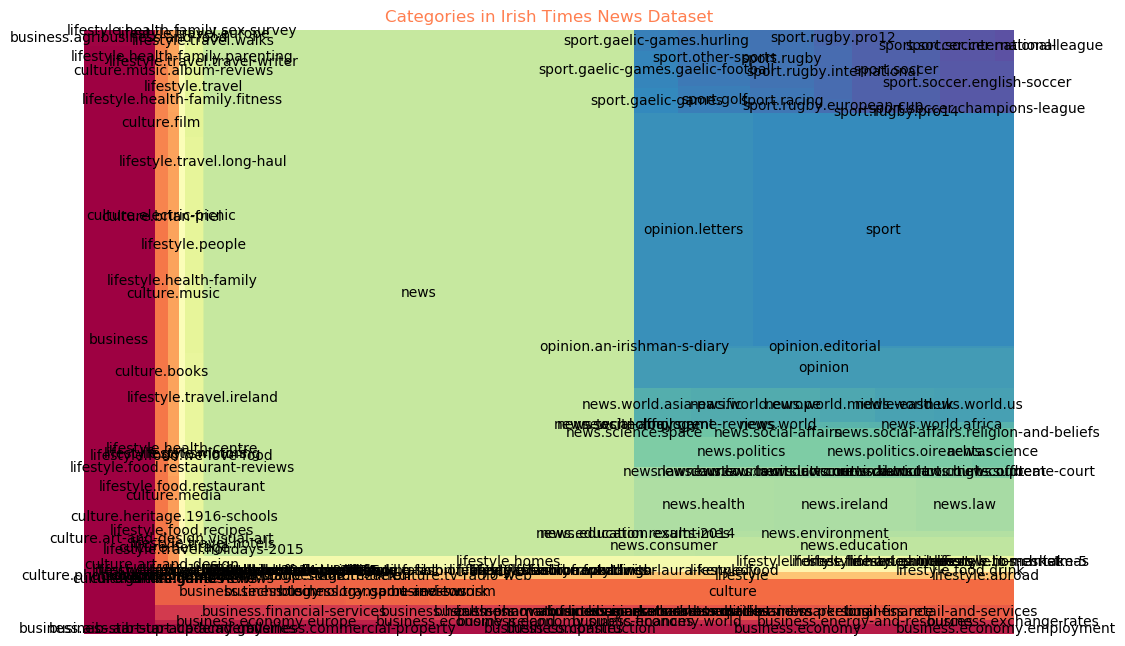

In [18]:
#****Code to visualize categories in news dataset********
import squarify 
import pandas as pd
import matplotlib.pyplot as plt
# Import preprocessed csv file
df_raw = pd.read_csv("irishtimes-date-text.csv")

# Prepare Data
df = df_raw.groupby('headline_category').size().reset_index(name='counts')
sizes = df.apply(lambda x: int(x[1]), axis=1)
labels = df['headline_category'].values.tolist()
print("Total number of labels in the dataset:",len(labels))

colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize=(12,8), dpi= 100)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=1)
plt.title('Categories in Irish Times News Dataset',color="coral")
plt.axis('off')
plt.savefig('categories_original.png',bbox_inches='tight')
plt.show()
plt.close()

### Inferences from above plot:

The dataset from Kaggle has new headlines that are labeled into 156 categories. Clearly, data is heavily skewed towards "news" category, followed by sports. 53 percent of the headlines belong to "news" category. So, if we run any random algorithm on the dataset as is to classify the news healines and it classifies all of them as "news", we can still say we predict the headlines with 45-50 percent accuracy.

To ensure my algorithms learn the data without any bias, I defined the below two datasets-Dataset A and Dataset B. While both of these datasets are well balanced compared to the original dataset, each has it's  own set of advantages and disadvantages. Dataset A can classify any headline into one it's 6 categories. However, it is not really diverse. Dataset B considers only 19 most popular categories and hence can provide us with more diverse set of classification. This exercise is to compare how models perform on each of the datasets. 

### Dataset A: 
For this dataset, first I filter out all the categories with less than 1000 rows. Then, I use the roots of the labels hierarchy and merge all the labels under the root. For example, all the labels news.education, news.law, etc, are all merged into news label. By doing this, I have 6 categories in total. Since the data is still unbalanced, I downsample the data so that each category has 55,000 rows. 



Number of rows in Dataset after downsampling: 156


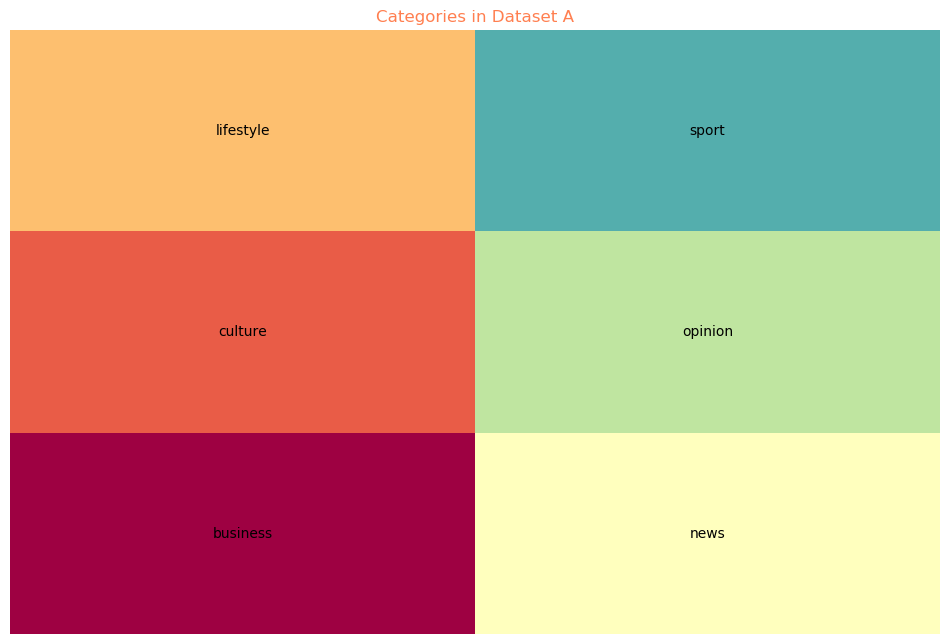

In [19]:
#****Code to build Dataset A from original news dataset and visualize the data********
import squarify 
import pandas as pd
import matplotlib.pyplot as plt
# Import Data
dataset_A = pd.read_csv("irishtimes-date-text.csv")
#Remove all categories with < 1000 entries
dataset_A = dataset_A[dataset_A.groupby('headline_category').headline_category.transform(len)>1000]
#Merge all the sub categories like new.law, news.health into news.
dataset_A.headline_category = dataset_A.headline_category.apply(lambda x: x.split(".")[0])
#Downsample the data to make it balanced
def sampling_k_elements(group, k=55000):
    return group.sample(k)
dataset_A = dataset_A.groupby('headline_category').apply(sampling_k_elements).reset_index(drop=True)
print("Number of rows in Dataset after downsampling:",len(df))
dataset_A = dataset_A.groupby('headline_category').size().reset_index(name='counts')
sizes = dataset_A.apply(lambda x: int(x[1]), axis=1)
labels = dataset_A['headline_category'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
plt.figure(figsize=(12,8), dpi= 100)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=1)
plt.title('Categories in Dataset A',color="coral")
plt.axis('off')
plt.savefig('categories_6.png',bbox_inches='tight')
plt.show()

### Dataset B: 

I applied this approach to get more diverse categories. I found that among the 156 categories, only few of them have large number of rows and the rest have relatively very few rows. So, I filter all rows with less than 10,000 rows. The result is 19 categories. Again, I downsample the data to 10,000 rows for each category to solve the unbalanced labels issue.

Number of rows in Dataset after downsampling: 156
Total number of labels in Dataset B: 21


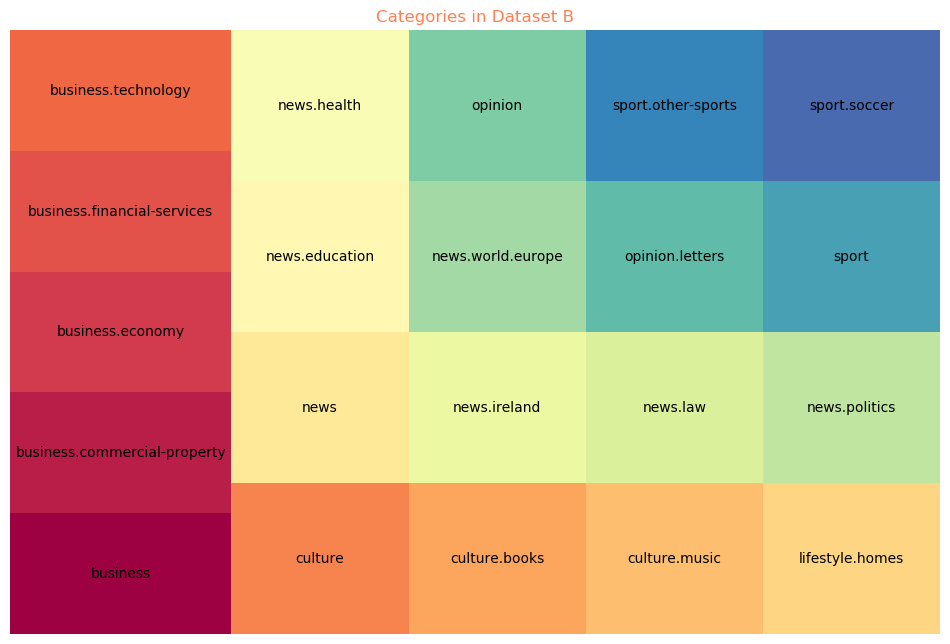

In [20]:
import squarify 
import pandas as pd
import matplotlib.pyplot as plt
# Import Data
dataset_B = pd.read_csv("irishtimes-date-text.csv")

#Filter of categories with less than 10000 entries
dataset_B = dataset_B[dataset_B.groupby('headline_category').headline_category.transform(len)>10000] #19 categories
#Downsample the data to make it balanced
def sampling_k_elements(group, k=10000):
    return group.sample(k)
dataset_B = dataset_B.groupby('headline_category').apply(sampling_k_elements).reset_index(drop=True)
print("Number of rows in Dataset after downsampling:",len(df))
dataset_B = dataset_B.groupby('headline_category').size().reset_index(name='counts')
sizes = dataset_B.apply(lambda x: int(x[1]), axis=1)

labels = dataset_B['headline_category'].values.tolist()
print("Total number of labels in Dataset B:",len(labels))
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
plt.figure(figsize=(12,8), dpi= 100)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=1)
plt.title('Categories in Dataset B',color="coral")
plt.axis('off')
plt.savefig('categories_19.png',bbox_inches='tight')
plt.show()

## PREPROCESS the data

The main preprocessing tasks applied to the 1.4 million headlines in our dataset are lemmatization, stopwords removal and tokenization.

In [23]:
## Code for preprocessing

#function to lemmatize a token/word
def lemmatize(text):
    #lemmatize- links words with similar meaning to one word.Like good, better , best would be converted to good.
    #lemmatize ensures that the essence of the word still remains the same.
    return (WordNetLemmatizer().lemmatize(text, pos='v'))
#Function to tokenize and remove stopwords.
def preprocess(text):
    string = " "
#gensim.utils.simple_preprocess tokenizes a sentence splitting it into words and replacing punctuations
    for token in gensim.utils.simple_preprocess(text):
        #ignore commonly used words(then,you,it) and words with length <=3
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            string = string + " "+ lemmatize(token)
    return string

print('tokenized and lemmatized new headlines')
df = pd.read_csv("irishtimes-date-text.csv")
df['preprocess']  = df['headline_text'].map(preprocess)


tokenized and lemmatized new headlines


In [24]:
# We can see how headlines in "preprocess" columns do not have filler words like about, as etc.,
df[['headline_text','preprocess']].head()

,headline_text,preprocess
0,UUP sees possibility of voting Major out,see possibility vote major
1,Pubs targeted as curbs on smoking are extended,pubs target curb smoke extend
2,Papers reveal secret links with O'Neill cabinet,paper reveal secret link neill cabinet
3,Domestic chaos as Italy takes EU presidency,domestic chaos italy take presidency
4,Learning about the star to which we owe life,learn star life


Since Machine Learning/Deep Learning models cannot accept words , we need to convert text into vector embeddings of integers/floating point numbers. For our experiments, each headline text could be represented as an aggregation or concatenation of its word vectors. I used a pretrained word embedding- GLoVe based on a large dictionary of words, that would include most of the news dataset vocabulary. Using pre trained Glove embedding, I map each word in the headline to a 100D vector.


# Classify headlines for Dataset A

## Split dataset into train, test and validation  and prepare word embedding

To ensure each dataset training,test and valdiation has all the categories,  I opted for stratified sampling. During stratification each headline is divided into homogeneous subgroups called stratum before sampling. Then simple random sampling is applied within each stratum so that sampling of the dataset is more balanced. In all the experiments, I first perform stratified sampling on the entire dataset to divide it into 60 % of training data comprising of all the categories and I again perform stratified sampling on the remaining 40 % of the dataset to divide in into validation and test datasets each comprising 20 % of original dataset.

In [43]:
#prepare Dataset A
df=pd.read_csv("irish-news_preprocessed.csv")
df = df[df['headline_text'].apply(lambda x: len(x) > 20)]
dataset_A = df[df.groupby('headline_category').headline_category.transform(len)>1000]
#Merge all the sub categories like new.law, news.health into news.
dataset_A.headline_category = dataset_A.headline_category.apply(lambda x: x.split(".")[0])

#Downsample the data to make it balanced
def sampling_k_elements(group, k=55000):
    return group.sample(k)
dataset_A = dataset_A.groupby('headline_category').apply(sampling_k_elements).reset_index(drop=True)
print("unique headlines are",dataset_A['headline_category'].unique())
# Max number of words in each text.
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
tokenizer = Tokenizer(num_words=MAX_NB_WORDS,lower=True)
#Tokenizer fit_on_texts creates a word index dictionary with each unique word and number assigned 
#to it. For ex., {"good":1,"samaritan":2,"a":3}
tokenizer.fit_on_texts(dataset_A.headline_text)
word_index = tokenizer.word_index
print('Found %s unique tokens in the dataset:' % len(word_index))
#Tokenizer texts_to_sequences converts a headline to a sequence of numbers from word index
#For example "a good samaritan" will be [[3, 2, 1]]
sequences = tokenizer.texts_to_sequences(dataset_A.headline_text)
#pad_sequences ensures each headline is of same size. pads zeros at the begginning if a sentence
# length is <MAX_SEQUENCE_LENGTH. For ex., "a good samaritan" will be 247 zeros-[[0,0,0,0,....,3,2,1]]
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
#one hot encode labels
labels = pd.get_dummies(dataset_A.headline_category).values
#****stratified Sampling******
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)
sss.get_n_splits(data, labels)
for train_index, test_index in sss.split(data, labels):
    x_train = data[[train_index]]
    y_train = labels[[train_index]]
    x_test_full = data[[test_index]]
    y_test_full = labels[[test_index]]
    
print("Length of Training dataset", len(y_train))


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
sss.get_n_splits(x_test_full, y_test_full)
for train_index, test_index in sss.split(x_test_full, y_test_full):
    x_test = x_test_full[[train_index]]
    y_test = y_test_full[[train_index]]
    x_val = x_test_full[[test_index]]
    y_val = y_test_full[[test_index]]
    #x_train, x_test = df['preprocess'].train_index, df['preprocess'].test_index
    #y_train, y_test = y[train_index], y[test_index]
    
print("Length of test dataset:",len(y_test))
print("Length of validation dataset:",len(y_val))

/Users/pguttula/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


unique headlines are ['business' 'culture' 'lifestyle' 'news' 'opinion' 'sport']
Found 90226 unique tokens in the dataset:


/Users/pguttula/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/pguttula/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/pguttula/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whic

Length of Training dataset 198000
Length of test dataset: 66000
Length of validation dataset: 66000


/Users/pguttula/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/pguttula/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/pguttula/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whic

"glove.6B.100d.txt" file contains a 100 dimension vector mapped to each word in it's corpus. this embedding is mapped to the words in our dataset and fed to learning algorithms.

In [44]:
#Import Keras library
from keras.models import Sequential, Model
from keras.layers import *
from keras.models import model_from_json
import matplotlib.pyplot as plt
from numpy.random import seed
seed(1)
#*****create embedding matrix for Machine Learning models from Glove****
#embeddings_index dictionary to have "key value pair word":list of coefficients for each word in
#the file glove.6B.100d.txt.
embeddings_index = {}
f = open('glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
#Embedding matrix to have # of rows = number of unique words in dataset. Each column will be the 
#coefficients in embeddings_index.
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [45]:
print("Shape of embedding matrix:",embedding_matrix.shape)

Shape of embedding matrix: (90227, 100)


## 1D CNN model
This model consists of three CNN 1D layers. The CNN layer is composed of 1D filters applied on the word embeddings to extract higher level features. The layers are formed of 128, 64 and 64 filters respectively. Each filter is of size 5 and uses ReLU activation function. Since CNNs are sensitive to features locations, we add MaxPooling layers after the last CNN layer, which down samples the feature maps of the CNN. This makes the network less sensitive to features position changes.
Finally, we add a Dense layer with Softmax classifier that outputs a probability for each class label. The label with highest probability is selected as the final label. 

In [47]:
from keras.models import save_model
from keras.models import model_from_json

def save_model(model):
    # serialize model to JSON
    model_json = model.to_json()
    with open('cnnlstmmodel6.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('cnnlstmmodel6.h5')

nb_labels = len(dataset_A['headline_category'].unique())
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))

model.add(Conv1D(128, 5, activation='relu', data_format='channels_first'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu', data_format='channels_first'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(nb_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 64
print(np.shape(y_train),np.shape(y_val),np.shape(y_test))
## train model for 50 epochs
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=50, batch_size=128)

save_model(model)

(198000, 6) (66000, 6) (66000, 6)
Train on 198000 samples, validate on 66000 samples
Epoch 1/50
198000/198000 [==============================] - 360s 2ms/step - loss: 1.0822 - accuracy: 0.6052 - val_loss: 1.0150 - val_accuracy: 0.6311
Epoch 2/50
198000/198000 [==============================] - 367s 2ms/step - loss: 0.9784 - accuracy: 0.6454 - val_loss: 0.9721 - val_accuracy: 0.6467
Epoch 3/50
198000/198000 [==============================] - 355s 2ms/step - loss: 0.9389 - accuracy: 0.6587 - val_loss: 0.9522 - val_accuracy: 0.6550
Epoch 4/50
198000/198000 [==============================] - 357s 2ms/step - loss: 0.9073 - accuracy: 0.6711 - val_loss: 0.9590 - val_accuracy: 0.6513
Epoch 5/50
198000/198000 [==============================] - 362s 2ms/step - loss: 0.8810 - accuracy: 0.6807 - val_loss: 0.9479 - val_accuracy: 0.6560
Epoch 6/50
198000/198000 [==============================] - 354s 2ms/step - loss: 0.8552 - accuracy: 0.6893 - val_loss: 0.9434 - val_accuracy: 0.6607
Epoch 7/50
1980

In [52]:
#y_pred has probabilities for each class for each row
y_pred = model.predict(x_test)
#to get the class with highest probability
prediction = np.argmax(y_pred,axis=1)
#to get class of true values
t_prediction = np.argmax(y_test,axis=1)

In [62]:
from sklearn.metrics import accuracy_score
print("Accuracy on test dataset",accuracy_score(t_prediction, prediction))
from sklearn.metrics import f1_score
print("f1_score on test dataset",f1_score(t_prediction, prediction,average='macro'))

Accuracy on test dataset 0.5865151515151515
f1_score on test dataset 0.5859969085779677


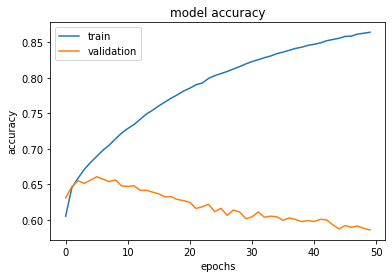

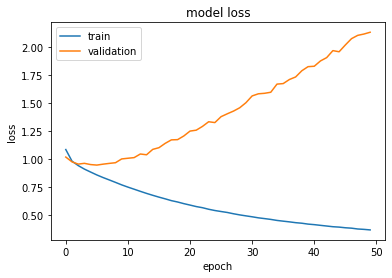

In [64]:
# summarize history for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('accuracy_6cat.png',bbox_inches='tight')
plt.show()
# summarize history  for loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_6cat.png',bbox_inches='tight')
plt.show()

In [66]:
from keras.models import save_model
from keras.models import model_from_json

def save_model(model):
    # serialize model to JSON
    model_json = model.to_json()
    with open('cnnlstmmodel6.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('cnnlstmmodel6.h5')

nb_labels = len(dataset_A['headline_category'].unique())
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
model.add(Conv1D(128, 5, activation='relu', data_format='channels_first'))
model.add(MaxPooling1D(5))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.5))
model.add(Dense(nb_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 64
print(np.shape(y_train),np.shape(y_val),np.shape(y_test))
## train model for 50 epochs
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=128)

save_model(model)

(198000, 6) (66000, 6) (66000, 6)
Train on 198000 samples, validate on 66000 samples
Epoch 1/20
198000/198000 [==============================] - 725s 4ms/step - loss: 1.1160 - accuracy: 0.5902 - val_loss: 1.0286 - val_accuracy: 0.6213
Epoch 2/20
198000/198000 [==============================] - 729s 4ms/step - loss: 1.0009 - accuracy: 0.6373 - val_loss: 0.9845 - val_accuracy: 0.6402
Epoch 3/20
198000/198000 [==============================] - 797s 4ms/step - loss: 0.9611 - accuracy: 0.6515 - val_loss: 0.9580 - val_accuracy: 0.6515
Epoch 4/20
198000/198000 [==============================] - 817s 4ms/step - loss: 0.9336 - accuracy: 0.6630 - val_loss: 0.9373 - val_accuracy: 0.6600
Epoch 5/20
198000/198000 [==============================] - 754s 4ms/step - loss: 0.9090 - accuracy: 0.6710 - val_loss: 0.9290 - val_accuracy: 0.6624
Epoch 6/20
198000/198000 [==============================] - 750s 4ms/step - loss: 0.8876 - accuracy: 0.6789 - val_loss: 0.9209 - val_accuracy: 0.6664
Epoch 7/20
1980

In [68]:
#y_pred has probabilities for each class for each row
y_pred = model.predict(x_test)
#to get the class with highest probability
prediction = np.argmax(y_pred,axis=1)
#to get class of true values
t_prediction = np.argmax(y_test,axis=1)
from sklearn.metrics import accuracy_score
print("Accuracy on test dataset",accuracy_score(t_prediction, prediction))
from sklearn.metrics import f1_score
print("f1_score on test dataset",f1_score(t_prediction, prediction,average='macro'))

Accuracy on test dataset 0.6632272727272728
f1_score on test dataset 0.6617573712770262


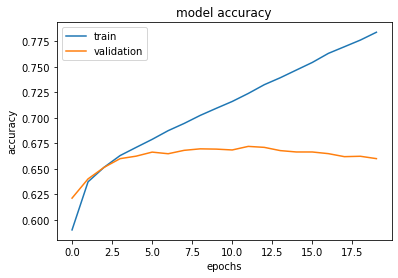

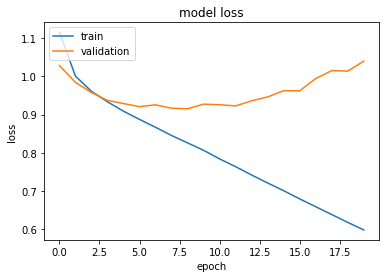

In [69]:
# summarize history for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('accuracy_6cat_LSTM.png',bbox_inches='tight')
plt.show()
# summarize history  for loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_6cat_LSTM.png',bbox_inches='tight')
plt.show()